# Εργασία 2 (Τεχνικές Εξόρυξης Δεδομένων)
## Data Mining: Assignment 2
***
### Μαρία Φριτζελά 1115201400218
***

In [65]:
import glob
import csv
import re
import pandas as pd
import numpy as np
from itertools import chain
from IPython.core.display import display
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import  svm, metrics
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import gensim

[nltk_data] Downloading package punkt to /home/mfritz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mfritz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Κατηγοριοποίηση δεδομένων κειμένου από ειδησιογραφικά άρθρα 5 κατηγοριών:</br>
Classifying text data from articles of 5 different categories:

In [2]:
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

### Get names of files for testing and training
Data set consists of 2225 documents from a news website
corresponding to stories in five topical areas from 2004-2005.</br>
</br>
80% of data points (files) will be used for training, the remaining 20% will be used for testing.</br>
We will be collecting the files names as elements in two lists (one for each purpose)

In [3]:
files_path = 'fulltext/data/'
train_files = []    # list of files names that will be used for training
test_files = []     # list of files names that will be used for testing

for category in categories:
    # get all txt files names from current category
    files = glob.glob(files_path+category+'/*.txt')
    # sort them alphabetically
    files.sort()
    # separate list so that first 80% will be copied into the train_files list
    sep_index = round(len(files) * 0.8)
    train_files.extend(files[:sep_index])
    test_files.extend(files[sep_index:])

Result:

In [4]:
print("Total files: 2225")
print("# of train files: "+str(len(train_files)))
print("# of test files: "+str(len(test_files)))

Total files: 2225
# of train files: 1781
# of test files: 444


### Create file train_set.tsv
Columns: id, title, content, category <br>
_The id is the name of the text file with the first letter of the category prepended (ex. "b001")_

In [5]:
with open('train_set.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    # write header row
    tsv_writer.writerow(['id', 'title', 'content', 'category'])
    # write rows for all other files
    for file_path in train_files:
        with open(file_path) as f:
            # read all lines of file split them in a list removing '\n'
            # iterate through elements in list removing empty ones (empty strings are False)
            try:
                content = [line for line in f.read().splitlines() if line.strip()]
                # unpack the information we need from the file path
                _, _, cat, name, _ = file_path.replace('.', '/').split('/')
                # Write row
                tsv_writer.writerow([cat[0]+name,
                                 content.pop(0),
                                 " ".join(content),
                                 cat])
            except UnicodeDecodeError:
                print("UnicodeDecodeError for file: "+file_path+". File skipped")


UnicodeDecodeError for file: fulltext/data/sport/199.txt. File skipped


### Create file test_set.tsv
Columns: id, title, content

In [6]:
with open('test_set.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    # write header row
    tsv_writer.writerow(['id', 'title', 'content'])
    # write rows for all other files
    for file_path in test_files:
        with open(file_path) as f:
            # read all lines of file split them in a list removing '\n'
            # iterate through elements in list removing empty ones (empty strings are False)
            try:
                content = [line for line in f.read().splitlines() if line.strip()]
                # unpack the information we need from the file path
                _, _, cat, name, _ = file_path.replace('.', '/').split('/')
                # Write row
                tsv_writer.writerow([cat[0]+name,
                                 content.pop(0),
                                 " ".join(content)])
            except UnicodeDecodeError:
                print("UnicodeDecodeError for file: "+file_path+". File skipped")

### Create a file with the full dataset: dataset.tsv


In [5]:
with open('dataset.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    # write header row
    tsv_writer.writerow(['id', 'title', 'content', 'category'])
    # write rows for all other files
    for file_path in chain(train_files, test_files):
        with open(file_path) as f:
            # read all lines of file split them in a list removing '\n'
            # iterate through elements in list removing empty ones (empty strings are False)
            try:
                content = [line for line in f.read().splitlines() if line.strip()]
                # unpack the information we need from the file path
                _, _, cat, name, _ = file_path.replace('.', '/').split('/')
                # Write row
                tsv_writer.writerow([cat[0]+name,
                                 content.pop(0),
                                 " ".join(content),
                                 cat])
            except UnicodeDecodeError:
                print("UnicodeDecodeError for file: "+file_path+". File skipped")

UnicodeDecodeError for file: fulltext/data/sport/199.txt. File skipped


Create a DataFrame for the data_set (id column as the index)

In [8]:
#testdf = pd.read_csv("test_set.tsv", sep='\t', index_col='id')
#traindf = pd.read_csv("train_set.tsv", sep='\t', index_col='id')
datadf = pd.read_csv("dataset.tsv", sep='\t', index_col='id')
datadf

,title,content,category
id,,,
b001,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,business
b002,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,business
b003,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,business
b004,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,business
b005,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,business
...,...,...,...
t397,BT program to beat dialler scams,BT is introducing two initiatives to help beat...,tech
t398,Spam e-mails tempt net shoppers,Computer users across the world continue to ig...,tech
t399,Be careful how you code,A new European directive could put software wr...,tech


## 1 Δημιουργία WordCloud
**Create a WordCloud for the articles of each category**

In [6]:
# Create our own stopWord list:
stopwords = set(STOPWORDS)
stopwords.update(['say', 'said', 'saying', 'will', 'many', 'new', 'people', 'now', 'one'])

### Business

In [10]:
#create wordcloud
# select rows where the id contains 'b' (=business) using filter
wordcloud_business = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(" ".join(title+' '+content
                                             for title, content in datadf.filter(like='b', axis=0)
                                                                   [['title', 'content']].values.tolist()))

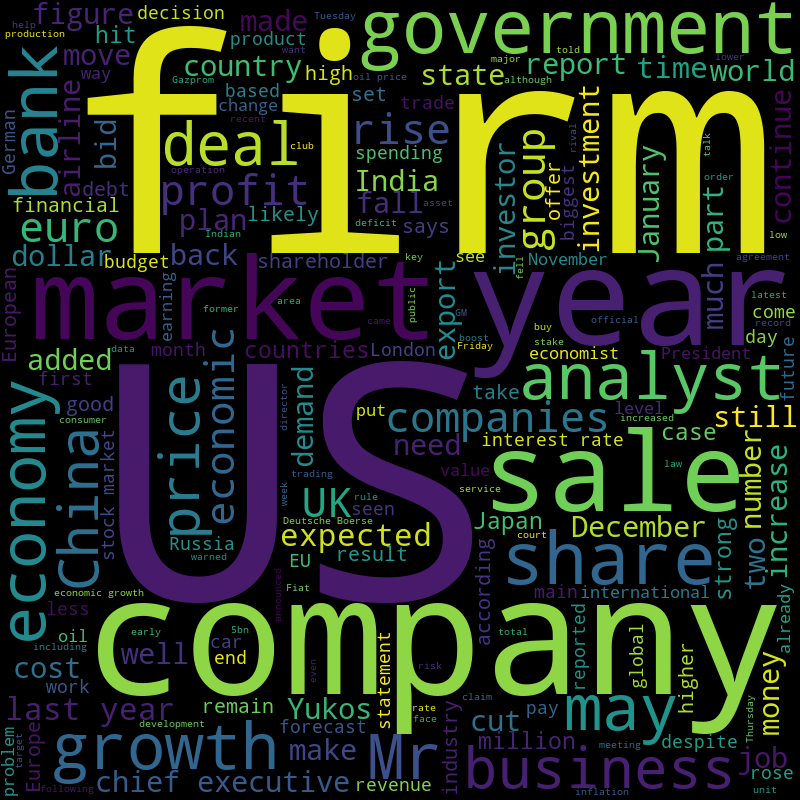

In [11]:
business_image = wordcloud_business.to_image()
display(business_image)

### Entertainment

In [12]:
wordcloud_entertainment = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(datadf.filter(like='e', axis=0)[['title', 'content']].values))

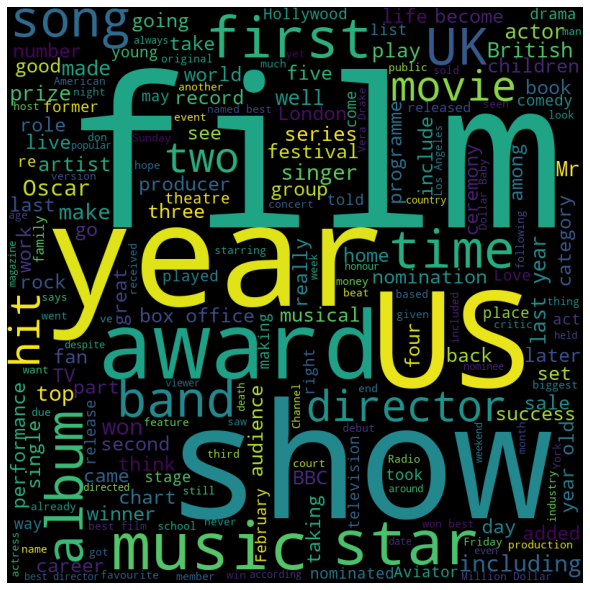

In [13]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_entertainment)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Politics

In [14]:
wordcloud_politics = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(datadf.filter(like='p', axis=0)[['title', 'content']].values))

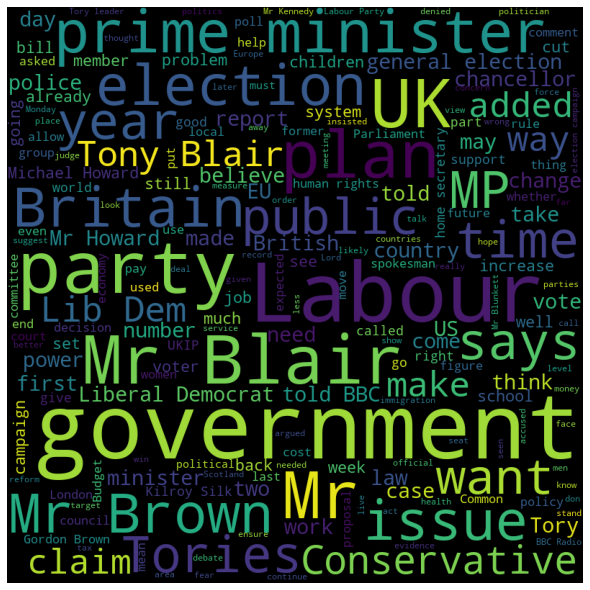

In [15]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_politics)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Sport

In [16]:
wordcloud_sport = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(datadf.filter(like='s', axis=0)[['title', 'content']].values))

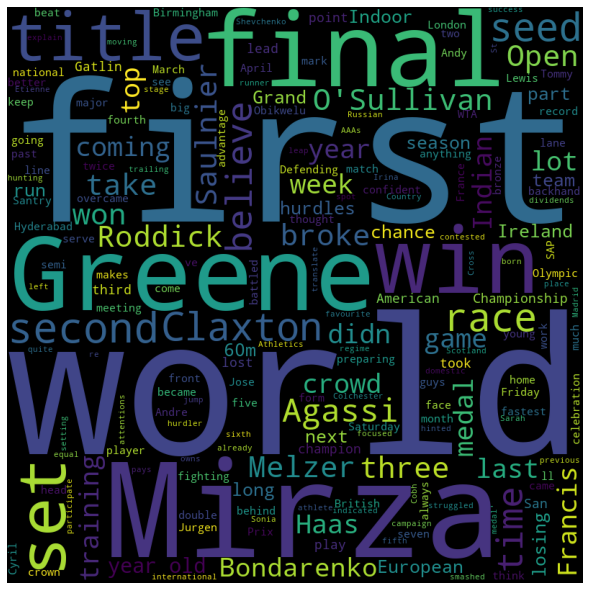

In [17]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_sport)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Tech

In [18]:
wordcloud_tech = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(datadf.filter(like='t', axis=0)[['title', 'content']].values))

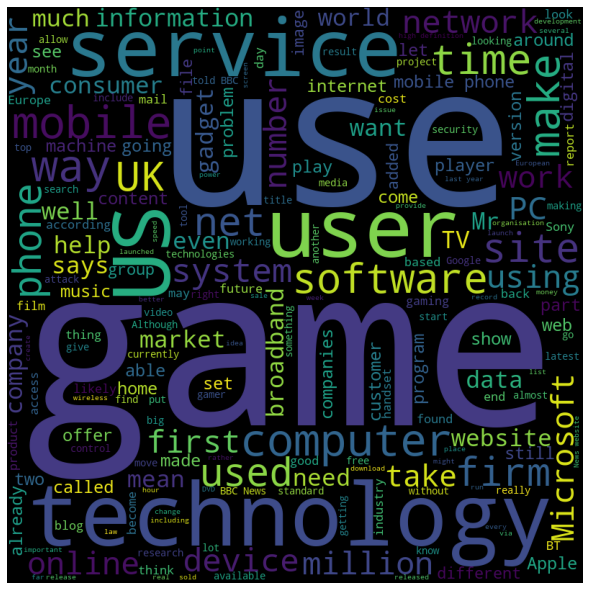

In [19]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_tech)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## 2 Υλοποίηση Κατηγοριοποίησης (Classification)
**Data Classification**

### A) Cleaning and Pre-processing the data
Create a Pandas Series, adding it as a new row into the datadf,
by concatenating the title and content column of the datadf <br>
Clean up text:<br>
- Add a space before performing the sum to not connect words together accidentally
- Make all the words lower case to facilitate clean up, using `.lower`
- Remove our list of stopwords
- Remove punctuation and special characters using `re.sub`
- Remove all words containing digits, and any digits using `re.sub`.

In [9]:
datadf['text'] = datadf[['title', 'content']]\
    .apply(lambda row: ' '.join(row.values.astype(str)), axis=1)\
    .apply(lambda item: list(filter(lambda word: word not in stopwords, item.lower().split())))\
    .apply(lambda item: re.sub('[^A-Za-z0-9 ]+', '', ' '.join(item)))\
    .apply(lambda item: re.sub(r'\w*\d\w*', '', item))


Now our datadf DataFrame looks like this, with the new column 'text':

In [10]:
datadf

,title,content,category,text
id,,,,
b001,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,business,ad sales boost time warner profit quarterly pr...
b002,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,business,dollar gains greenspan speech dollar hit highe...
b003,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,business,yukos unit buyer faces loan claim owners embat...
b004,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,business,high fuel prices hit bas profits british airwa...
b005,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,business,pernod takeover talk lifts domecq shares uk dr...
...,...,...,...,...
t397,BT program to beat dialler scams,BT is introducing two initiatives to help beat...,tech,bt program beat dialler scams bt introducing t...
t398,Spam e-mails tempt net shoppers,Computer users across the world continue to ig...,tech,spam emails tempt net shoppers computer users ...
t399,Be careful how you code,A new European directive could put software wr...,tech,careful code european directive put software w...


Seperate data into train (80%) and test (20%) set <br>
Use the stratify parameter to ensure that the split between the different categories is done equally

In [11]:
X_train, X_test, y_train, y_test = train_test_split(datadf.text, datadf.category,
                                                    test_size=0.2, stratify=datadf.category)

#### Bag-of-words
Create bag-of-words vector

In [12]:
bow_vectorizer = CountVectorizer(max_features=3000, stop_words='english')

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)


In [13]:
pd.DataFrame(X_train_bow[0:1].T.todense(), index=bow_vectorizer.get_feature_names(), columns=["counts"])\
.sort_values(by=["counts"],ascending=False)

,counts
mr,10
labours,6
milburn,5
prescott,4
election,4
...,...
filesharing,0
filing,0
film,0
films,0


#### TF-IDF

In [15]:
tfidf_vectorizer= TfidfVectorizer(ngram_range=(1,2), max_features=3000, stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [16]:
pd.DataFrame(X_train_tfidf[0:1].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])\
.sort_values(by=["tfidf"],ascending=False)

,tfidf
milburn,0.308689
labours,0.286747
mr milburn,0.281005
prescott,0.263706
mr,0.234939
...,...
financial,0.000000
finding,0.000000
fine,0.000000
finish,0.000000


### B) Classification

#### Support Vector Machines (SVM)
<u>*Bag of Words*</u>


In [114]:
#instantiate the model
svm_clf = svm.SVC()

# train the model on the BoW training set
svm_clf.fit(X_train_bow, y_train)
# predict the BoW test set
y_pred_svm_bow = svm_clf.predict(X_test_bow)

In [115]:
print("10-fold Cross Validation Precision SVM for BoW:",
      np.mean(cross_val_score(svm_clf, X_train_bow, y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall SVM for BoW:",
      np.mean(cross_val_score(svm_clf, X_train_bow, y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure SVM for BoW:",
     np.mean(cross_val_score(svm_clf, X_train_bow, y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy SVM for BoW:",
      np.mean(cross_val_score(svm_clf, X_train_bow, y_train, cv=10, scoring='accuracy')))

10-fold Cross Validation Precision SVM for BoW: 0.9551005897656465
10-fold Cross Validation Recall SVM for BoW: 0.9537246020860243
10-fold Cross Validation F-Measure SVM for BoW: 0.95350786048915
10-fold Cross Validation Accuracy SVM for BoW: 0.9544721640322479


<u>*TF/IDF*</u>

In [31]:
# train the model on the TF/IDF training set (previous weights and variables are reset)
svm_clf.fit(X_train_tfidf, y_train)
# predict the TF/IDF test set
y_pred_svm_tfidf = svm_clf.predict(X_test_tfidf)

In [32]:
print("10-fold Cross Validation Precision SVM for TF/IDF:",
      np.mean(cross_val_score(svm_clf, X_train_tfidf, y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall SVM for TF/IDF:",
      np.mean(cross_val_score(svm_clf, X_train_tfidf, y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure SVM for TF/IDF:",
     np.mean(cross_val_score(svm_clf, X_train_tfidf, y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy SVM for TF/IDF:",
      np.mean(cross_val_score(svm_clf, X_train_tfidf, y_train, cv=10, scoring='accuracy')))

10-fold Cross Validation Precision SVM for TF/IDF: 0.9764879713978643
10-fold Cross Validation Recall SVM for TF/IDF: 0.9751071564560305
10-fold Cross Validation F-Measure SVM for TF/IDF: 0.9755622627112333
10-fold Cross Validation Accuracy SVM for TF/IDF: 0.9758268266361962


#### Random Forest
<u>*Bag of Words*</u>

In [44]:
# Instantiate the model
rf = RandomForestClassifier()

# Train the model on the BoW training set
rf.fit(X_train_bow, y_train)
# predict the BoW test set
y_pred_rf_bow = rf.predict(X_test_bow)

In [34]:
print("10-fold Cross Validation Precision RF for BoW:",
      np.mean(cross_val_score(rf, X_train_bow, y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall RF for BoW:",
      np.mean(cross_val_score(rf, X_train_bow, y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure RF for BoW:",
     np.mean(cross_val_score(rf, X_train_bow, y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy RF for BoW:",
      np.mean(cross_val_score(rf, X_train_bow, y_train, cv=10, scoring='accuracy')))

10-fold Cross Validation Precision RF for BoW: 0.9559221386621122
10-fold Cross Validation Recall RF for BoW: 0.9558172730217901
10-fold Cross Validation F-Measure RF for BoW: 0.9582740231107408
10-fold Cross Validation Accuracy RF for BoW: 0.9583952263061004


<u>*TF/IDF*</u>

In [35]:
# train the model on the TF/IDF training set (previous weights and variables are reset)
rf.fit(X_train_tfidf, y_train)
# predict the TF/IDF test set
y_pred_rf_tfidf = rf.predict(X_test_tfidf)

In [36]:
print("10-fold Cross Validation Precision RF for TF/IDF:",
      np.mean(cross_val_score(rf, X_train_tfidf, y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall RF for TF/IDF:",
      np.mean(cross_val_score(rf, X_train_tfidf, y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure RF for TF/IDF:",
     np.mean(cross_val_score(rf, X_train_tfidf, y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy RF for TF/IDF:",
      np.mean(cross_val_score(rf, X_train_tfidf, y_train, cv=10, scoring='accuracy')))

10-fold Cross Validation Precision RF for TF/IDF: 0.9585088891507088
10-fold Cross Validation Recall RF for TF/IDF: 0.956352722392154
10-fold Cross Validation F-Measure RF for TF/IDF: 0.9525677024094434
10-fold Cross Validation Accuracy RF for TF/IDF: 0.9550212657906432


#### Naive Bayes
<u>*Bag of Words*</u>

In [47]:
# Instantiate the model
nb = GaussianNB()

# Train the model on the BoW training set
nb.fit(X_train_bow.toarray(), y_train)
# predict the BoW test set
y_pred_nb_bow = nb.predict(X_test_bow.toarray())

In [38]:
print("10-fold Cross Validation Precision NB for BoW:",
      np.mean(cross_val_score(nb, X_train_bow.toarray(), y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall NB for BoW:",
      np.mean(cross_val_score(nb, X_train_bow.toarray(), y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure NB for BoW:",
     np.mean(cross_val_score(nb, X_train_bow.toarray(), y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy NB for BoW:",
      np.mean(cross_val_score(nb, X_train_bow.toarray(), y_train, cv=10, scoring='accuracy')))

10-fold Cross Validation Precision NB for BoW: 0.9211511593926497
10-fold Cross Validation Recall NB for BoW: 0.9174121936844261
10-fold Cross Validation F-Measure NB for BoW: 0.9163433970902914
10-fold Cross Validation Accuracy NB for BoW: 0.9185075858566624


<u>*TF/IDF*</u>

In [39]:
# Train the model on the TF/IDF training set (previous weights and variables are reset)
nb.fit(X_train_tfidf.toarray(), y_train)
# predict the TF/IDF test set
y_pred_nb_tfidf = nb.predict(X_test_tfidf.toarray())

In [40]:
print("10-fold Cross Validation Precision NB for TF/IDF:",
      np.mean(cross_val_score(nb, X_train_tfidf.toarray(), y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall NB for TF/IDF:",
      np.mean(cross_val_score(nb, X_train_tfidf.toarray(), y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure NB for TF/IDF:",
     np.mean(cross_val_score(nb, X_train_tfidf.toarray(), y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy NB for TF/IDF:",
      np.mean(cross_val_score(nb, X_train_tfidf.toarray(), y_train, cv=10, scoring='accuracy')))

10-fold Cross Validation Precision NB for TF/IDF: 0.916817434168703
10-fold Cross Validation Recall NB for TF/IDF: 0.9117711535332967
10-fold Cross Validation F-Measure NB for TF/IDF: 0.9115241879960069
10-fold Cross Validation Accuracy NB for TF/IDF: 0.9134577540785882


#### K-Nearest Neighbor

Create the majority voting function. It returns the value that appears more often in List. If two values have the same number of appearances in the list, it returns the first element of the list.

In [18]:
# avoided using Pythons mode for lists because of StatisticsError 
# which appears in case there is more than one mode in List

def maj_voting(List):
    # turn list into pandas series to use mode function
    # return first element of series returned by mode
    return pd.Series(List).mode().iloc[0]

We will be creating our own KNN estimator which will be scikit-learn-compatible

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KDTree

class MyKNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, leaf_size=40):
        self.n_neighbors = n_neighbors
        # leaf size for the KDTree
        self.leaf_size = leaf_size

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Create the KDTree
        self._tree = KDTree(X, self.leaf_size)
        
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        
        # Input validation
        X = check_array(X)

        #closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        closest_dist, closest_indices = self._tree.query(X, k=self.n_neighbors)
        return np.array(list(map(maj_voting, self.y_[closest_indices])))


Check whether estimator adheres to the scikit-learn interface and standards

In [20]:
from sklearn.utils.estimator_checks import check_estimator
check_estimator(MyKNNClassifier)

Use our custom classifier for our dataset (BoW and TF/IDF):

<u>*Bag of Words*</u>

In [40]:
# Instantiate the model
myclf = MyKNNClassifier(n_neighbors=4)

# Train the model on the BoW training set
myclf.fit(X_train_bow.toarray(), y_train)
# predict the BoW test set
y_pred_myknn_bow = myclf.predict(X_test_bow.toarray())

In [22]:
print("10-fold Cross Validation Precision MyKNN for BoW:",
      np.mean(cross_val_score(myclf, X_train_bow.toarray(), y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall MyKNN for BoW:",
      np.mean(cross_val_score(myclf, X_train_bow.toarray(), y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure MyKNN for BoW:",
     np.mean(cross_val_score(myclf, X_train_bow.toarray(), y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy MyKNN for BoW:",
      np.mean(cross_val_score(myclf, X_train_bow.toarray(), y_train, cv=10, scoring='accuracy')))

10-fold Cross Validation Precision MyKNN for BoW: 0.8230472719469308
10-fold Cross Validation Recall MyKNN for BoW: 0.5864515215677859
10-fold Cross Validation F-Measure MyKNN for BoW: 0.6118102386706742
10-fold Cross Validation Accuracy MyKNN for BoW: 0.6065098711356567


<u>*TF/IDF*</u>

In [41]:
# Train the model on the TFIDF training set
myclf.fit(X_train_tfidf.toarray(), y_train)
# predict the BoW test set
y_pred_myknn_tfidf = myclf.predict(X_test_tfidf.toarray())

In [24]:
print("10-fold Cross Validation Precision MyKNN for TF/IDF:",
      np.mean(cross_val_score(myclf, X_train_tfidf.toarray(), y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall MyKNN for TF/IDF:",
      np.mean(cross_val_score(myclf, X_train_tfidf.toarray(), y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure MyKNN for TF/IDF:",
     np.mean(cross_val_score(myclf, X_train_tfidf.toarray(), y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy MyKNN for TF/IDF:",
      np.mean(cross_val_score(myclf, X_train_tfidf.toarray(), y_train, cv=10, scoring='accuracy')))

10-fold Cross Validation Precision MyKNN for TF/IDF: 0.944984324293179
10-fold Cross Validation Recall MyKNN for TF/IDF: 0.9433747712231305
10-fold Cross Validation F-Measure MyKNN for TF/IDF: 0.9434117126656683
10-fold Cross Validation Accuracy MyKNN for TF/IDF: 0.9443439344886689


Accuracy Score on test data for different number of neighbors:<br>

| My KNN | BoW Accuracy | TF/IDF Accuracy |
|--------|--------------|-----------------|
| 2      | 0.72808      | 0.91235         |
| 3      | 0.68764      | 0.92584         |
| 4      | 0.68089      | 0.93932         |
| 5      | 0.64269      | 0.93483         |
| 6      | 0.62921      | 0.94606         |

#### Scores of Classifiers

In [46]:
#Model Precision: what percentage was classified correctly?
print("Precision SVM for BoW:",metrics.precision_score(y_test, y_pred_svm_bow, average=None))
print("Precision SVM for TF/IDF:",metrics.precision_score(y_test, y_pred_svm_tfidf, average=None))
print("Precision RF for BoW:",metrics.precision_score(y_test, y_pred_rf_bow, average=None))
print("Precision RF for TF/IDF:",metrics.precision_score(y_test, y_pred_rf_tfidf, average=None))
print("Precision NB for BoW:",metrics.precision_score(y_test, y_pred_nb_bow, average=None))
print("Precision NB for TF/IDF:",metrics.precision_score(y_test, y_pred_nb_tfidf, average=None))
print("Precision MyKNN for BoW:",metrics.precision_score(y_test, y_pred_myknn_bow, average=None))
print("Precision MyKNN for TF/IDF:",metrics.precision_score(y_test, y_pred_myknn_tfidf, average=None))

print()
# Model Recall
print("Recall SVM for BoW:",metrics.recall_score(y_test, y_pred_svm_bow, average=None))
print("Recall SVM for TF/IDF:",metrics.recall_score(y_test, y_pred_svm_tfidf, average=None))
print("Recall RF for BoW:",metrics.recall_score(y_test, y_pred_rf_bow, average=None))
print("Recall RF for TF/IDF:",metrics.recall_score(y_test, y_pred_rf_tfidf, average=None))
print("Recall NB for BoW:",metrics.recall_score(y_test, y_pred_nb_bow, average=None))
print("Recall NB for TF/IDF:",metrics.recall_score(y_test, y_pred_nb_tfidf, average=None))
print("Recall MyKNN for BoW:",metrics.recall_score(y_test, y_pred_myknn_bow, average=None))
print("Recall MyKNN for TF/IDF:",metrics.recall_score(y_test, y_pred_myknn_tfidf, average=None))

print()
# F-Measure
print("F-Measure SVM for BoW:", metrics.f1_score(y_test, y_pred_svm_bow, average=None))
print("F-Measure SVM for TF/IDF:", metrics.f1_score(y_test, y_pred_svm_tfidf, average=None))
print("F-Measure RF for BoW:", metrics.f1_score(y_test, y_pred_rf_bow, average=None))
print("F-Measure RF for TF/IDF:", metrics.f1_score(y_test, y_pred_rf_tfidf, average=None))
print("F-Measure NB for BoW:", metrics.f1_score(y_test, y_pred_nb_bow, average=None))
print("F-Measure NB for TF/IDF:", metrics.f1_score(y_test, y_pred_nb_tfidf, average=None))
print("F-Measure MyKNN for BoW:", metrics.f1_score(y_test, y_pred_myknn_bow, average=None))
print("F-Measure MyKNN for TF/IDF:", metrics.f1_score(y_test, y_pred_myknn_tfidf, average=None))

print()
# compare actual response values (y_test) with predicted response values (y_pred)
print("Accuracy SVM for BoW:",metrics.accuracy_score(y_test, y_pred_svm_bow))
print("Accuracy SVM for TF/IDF:",metrics.accuracy_score(y_test, y_pred_svm_tfidf))
print("Accuracy RF for BoW:",metrics.accuracy_score(y_test, y_pred_rf_bow))
print("Accuracy RF for TF/IDF:",metrics.accuracy_score(y_test, y_pred_rf_tfidf))
print("Accuracy NB for BoW:",metrics.accuracy_score(y_test,y_pred_nb_bow))
print("Accuracy NB for TF/IDF:",metrics.accuracy_score(y_test, y_pred_nb_tfidf))
print("Accuracy of My KNN for BoW:",metrics.accuracy_score(y_test, y_pred_myknn_bow))
print("Accuracy of My KNN for TF/IDF:",metrics.accuracy_score(y_test, y_pred_myknn_tfidf))

Precision SVM for BoW: [0.97       0.97435897 0.96428571 0.99009901 0.96341463]
Precision SVM for TF/IDF: [0.97979798 0.97435897 0.95402299 0.99029126 0.98717949]
Precision RF for BoW: [0.98979592 0.97333333 0.96428571 0.94444444 0.9375    ]
Precision RF for TF/IDF: [0.98979592 0.94805195 0.96428571 0.95283019 0.95      ]
Precision NB for BoW: [0.92       0.98507463 0.94186047 1.         0.81052632]
Precision NB for TF/IDF: [0.90291262 0.96875    0.91764706 0.98979592 0.81052632]

Recall SVM for BoW: [0.95098039 0.98701299 0.96428571 0.98039216 0.9875    ]
Recall SVM for TF/IDF: [0.95098039 0.98701299 0.98809524 1.         0.9625    ]
Recall RF for BoW: [0.95098039 0.94805195 0.96428571 1.         0.9375    ]
Recall RF for TF/IDF: [0.95098039 0.94805195 0.96428571 0.99019608 0.95      ]
Recall NB for BoW: [0.90196078 0.85714286 0.96428571 0.95098039 0.9625    ]
Recall NB for TF/IDF: [0.91176471 0.80519481 0.92857143 0.95098039 0.9625    ]

F-Measure SVM for BoW: [0.96039604 0.98064516 

**ROC Plots**

Create a function for plotting out ROC Curves for our multiclasses

In [157]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

def ROC_Plot(title, X_train, X_test, y_train, y_test, model=svm.SVC(kernel='linear')):
    # Binarize the output
    y_train_bin = label_binarize(y_train, classes=['business', 'entertainment', 
                                               'politics', 'sport', 'tech'])
    y_test_bin = label_binarize(y_test, classes=['business', 'entertainment', 
                                               'politics', 'sport', 'tech'])
    n_classes = y_train_bin.shape[1]
    
    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(model)
    try:
        y_score = classifier.fit(X_train, y_train_bin).decision_function(X_test)
    except AttributeError:
        y_score = classifier.fit(X_train, y_train_bin).predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot all ROC curves
    plt.figure()
    lw = 2
    colors = ['red', 'blue', 'aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Receiver operating characteristic to multi-class
    plt.title('ROC Plot: '+title)
    plt.legend(loc="lower right")
    plt.show()  

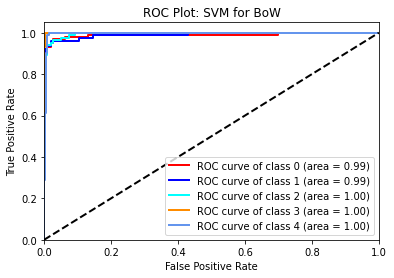

In [133]:
ROC_Plot("SVM for BoW",X_train_bow, X_test_bow, y_train, y_test)

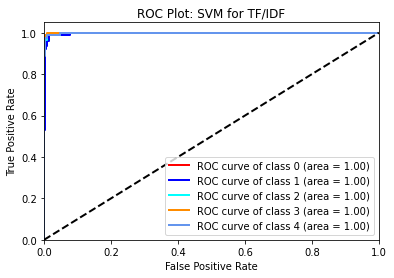

In [50]:
ROC_Plot("SVM for TF/IDF", X_train_tfidf, X_test_tfidf, y_train, y_test)

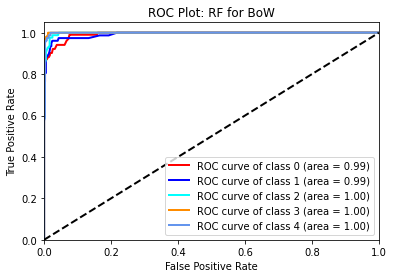

In [159]:
ROC_Plot("RF for BoW", X_train_bow, X_test_bow, y_train, y_test, model=RandomForestClassifier())

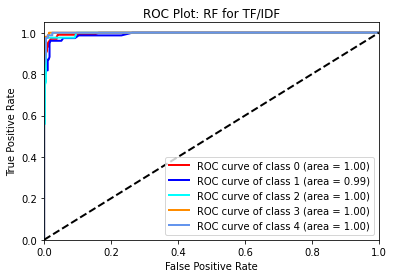

In [158]:
ROC_Plot("RF for TF/IDF", X_train_tfidf, X_test_tfidf, y_train, y_test, model=RandomForestClassifier())

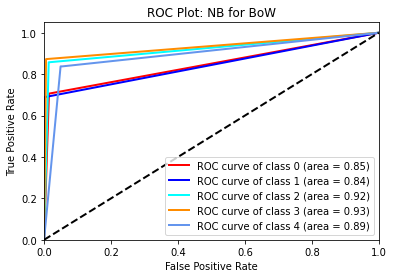

In [162]:
ROC_Plot("NB for BoW",X_train_bow.toarray(), X_test_bow.toarray(), y_train, y_test, model=GaussianNB())

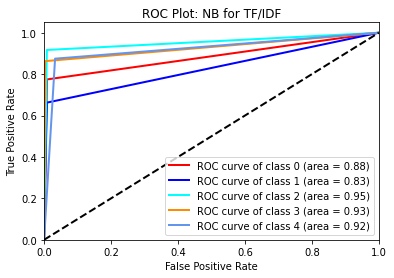

In [163]:
ROC_Plot("NB for TF/IDF", X_train_tfidf.toarray(), X_test_tfidf.toarray(), y_train, y_test, model=GaussianNB())

## 3) Beat the benchmark

We will see how lemmatization of words will improve the scores from the previous question.<br>
We will use the `WordNetLemmatizer` from nltk in the text column of our dataframe

In [74]:
lemmatizer = WordNetLemmatizer()

datadf.text = datadf.text.apply(lambda item: ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(item)]))

In [66]:
datadf

,title,content,category,text
id,,,,
b001,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,business,ad sale boost time warner profit quarterly pro...
b002,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,business,dollar gain greenspan speech dollar hit highes...
b003,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,business,yukos unit buyer face loan claim owner embattl...
b004,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,business,high fuel price hit ba profit british airway b...
b005,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,business,pernod takeover talk lift domecq share uk drin...
...,...,...,...,...
t397,BT program to beat dialler scams,BT is introducing two initiatives to help beat...,tech,bt program beat dialler scam bt introducing tw...
t398,Spam e-mails tempt net shoppers,Computer users across the world continue to ig...,tech,spam email tempt net shopper computer user acr...
t399,Be careful how you code,A new European directive could put software wr...,tech,careful code european directive put software w...


Seperate data into train (80%) and test (20%) set <br>
Use the stratify parameter to ensure that the split between the different categories is done equally

In [67]:
X_train, X_test, y_train, y_test = train_test_split(datadf.text, datadf.category,
                                                    test_size=0.2, stratify=datadf.category)

#### Bag-of-words
Create bag-of-words vector

In [68]:
bow_vectorizer = CountVectorizer(max_features=3000, stop_words='english')

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)


#### TF-IDF

In [69]:
tfidf_vectorizer= TfidfVectorizer(ngram_range=(1,2), max_features=3000, stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#### K-Nearest Neighbor (K=4)

In [75]:
# Using my knn model instantiated in question 2
# Train the model on the BoW training set
myclf.fit(X_train_bow.toarray(), y_train)
# predict the BoW test set
y_pred_myknn_bow = myclf.predict(X_test_bow.toarray())

In [71]:
# Train the model on the TFIDF training set
myclf.fit(X_train_tfidf.toarray(), y_train)
# predict the BoW test set
y_pred_myknn_tfidf = myclf.predict(X_test_tfidf.toarray())

In [72]:
print("Accuracy of My KNN for BoW:",metrics.accuracy_score(y_test, y_pred_myknn_bow))
print("Accuracy of My KNN for TF/IDF:",metrics.accuracy_score(y_test, y_pred_myknn_tfidf))

Accuracy of My KNN for BoW: 0.7370786516853932
Accuracy of My KNN for TF/IDF: 0.946067415730337


<u>Note:</u><br>
Previous Accuracy of My KNN (K=4) for BoW:	0.68089	(**Improvement: 0.05618**) <br>
Previous Accuracy of My KNN (K=4) for TF/IDF: 0.93932 (**Improvement: 0.02474**)

## 4) Υλοποίηση Συσταδοποίησης (Clustering)

We will be creating clustering of BoW, TFIDF, and Document-Embeddings arrays using K-means clustering with Cosine Similarity. 

### a) Preparing the Document arrays

We will be using the cleaned up 'text' column of our datadf DataFrame to create the different document representation arrays. 

#### Bag of Words

In [76]:
# using the instance of the bow_vectorizer we created for question 2 (classification)
bow_vectorizer = CountVectorizer(max_features=3000, stop_words='english')
# using fit_transform with the full data resets the features
X_bow = bow_vectorizer.fit_transform(datadf.text)

In [77]:
pd.DataFrame(X_bow[0:1].T.todense(), index=bow_vectorizer.get_feature_names(), columns=["counts"])\
.sort_values(by=["counts"],ascending=False)

,counts
profit,10
aol,5
sale,5
warner,4
internet,4
...,...
filmmaker,0
finally,0
finance,0
finding,0


#### TFIDF

In [78]:
# using the instance of the bow_vectorizer we created for question 2 (classification)
tfidf_vectorizer= TfidfVectorizer(ngram_range=(1,2), 
                                  max_features=3000, stop_words='english',
                                 sublinear_tf=True, use_idf=True)
# using fit_transform with the full data resets the features
X_tfidf = tfidf_vectorizer.fit_transform(datadf.text)

In [79]:
pd.DataFrame(X_tfidf[0:1].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["counts"])\
.sort_values(by=["counts"],ascending=False)

,counts
aol,0.266364
profit,0.225581
fourth quarter,0.196696
sec,0.171066
revenue,0.167159
...,...
fit,0.000000
fitness,0.000000
fix,0.000000
fixed,0.000000


#### Document - Embeddings

In [80]:
#import gensim

# Load Google's pre-trained Word2Vec model.
#model = gensim.models.Word2Vec.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)  

Doc2Vec is a Model that represents each Document as a Vector.<br>
For training it we need to have our data as a list of `TaggedDocument`s, with the tags being just keys into the doc-vectors collection. The tag of each document will be it's id.<br> 
To avoid having to instantiate the full dataset as a list in memory, we create `MyCorpus` class.

MyCorpus is an iterable object that, every time it is asked to iterate over the data (because Doc2Vec training will require multiple passes), can offer up each and every item in turn – but never reading the entire dataset into an in-memory object.

In [81]:
class MyCorpus(object):
    def __init__(self, source_series):
        self.source_series = source_series

    def __iter__(self):
        for index, document in self.source_series.iteritems():
            yield gensim.models.doc2vec.TaggedDocument(words=document, 
                                 tags=[index])

We create our corpus for the Doc2Vec model using our custom class

In [82]:
mycorpus = MyCorpus(datadf.text.apply(lambda item: item.split()))

Then we create the Doc2Vec model<br>
Because we have a small dataset (2225 documents), adding training passes can help (`epochs = Number of iterations (epochs) over the corpus.`).<br>
If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.

In [83]:
# Create model

d2v_model = gensim.models.doc2vec.Doc2Vec(dm=0, min_count=2, epochs=10) #vector_size=50 ?

# Build a vocabulary

d2v_model.build_vocab(mycorpus)

# Train the model on the corpus

d2v_model.train(mycorpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

Using the tag of a document to look-up the learned vector

In [84]:
d2v_model.docvecs['b001']

array([-1.12232022e-01, -1.64594963e-01,  1.50092930e-01, -1.38416290e-01,
       -2.37732515e-01, -3.24969262e-01, -2.32887462e-01, -1.49678797e-01,
        3.22863720e-02,  2.84513444e-01, -3.25257122e-03,  9.82520729e-02,
        3.65221947e-02,  3.66517603e-02,  1.35405764e-01,  3.11108589e-01,
       -2.34955445e-01,  1.02546327e-01, -3.83824348e-01,  3.10033828e-01,
        3.23633432e-01, -1.68558195e-01,  1.83436517e-02, -2.89335459e-01,
       -2.16676459e-01, -3.00938785e-02, -2.99468398e-01,  1.68198451e-01,
       -7.38487244e-02, -1.56976089e-01,  1.71959952e-01, -9.18386653e-02,
        2.80263455e-04, -8.37644096e-03, -4.58432257e-01, -3.31019849e-01,
       -7.59477243e-02,  1.65556911e-02,  3.41436803e-01,  2.90395826e-01,
        1.70514524e-01, -8.13405216e-02, -4.59538996e-01,  3.47129963e-02,
        1.67380825e-01, -4.95536774e-01, -4.27180439e-01,  6.18028678e-02,
        6.12215735e-02, -1.88553289e-01, -1.25955805e-01,  6.16495684e-02,
        1.09473795e-01,  

Check the size of the entire vector. Should be (DxE) where D=number of documents and E=embeddings size

In [85]:
d2v_model.docvecs.vectors_docs.shape

(2224, 100)

We will use this Document-Embeddings vector for the Clustering later

In [86]:
X_d2v = d2v_model.docvecs.vectors_docs

### b) Reducing Document arrays Dimensions for 2-D Plotting

We will be reducing the dimentionality of our BoW, TF/IDF, and D2V vectors using PCA, SVD and ICA.<br>
We will be plotting the results of each algorithm for every vector using a 4x4 matplotlib figure created by the following function

In [87]:
def visualize_2d_projection(X_bow, X_tfidf, X_d2v, title, colors, targets):
    bow_df = pd.DataFrame(X_bow, index=datadf.index, columns=["component 1", "component 2"])
    tfidf_df = pd.DataFrame(X_tfidf, index=datadf.index, columns=["component 1", "component 2"])
    d2v_df = pd.DataFrame(X_d2v, index=datadf.index, columns=["component 1", "component 2"])
    
    # Create figure and axes
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
    # ax1 = BoW
    ax1.set_xlabel('Component 1', fontsize = 15)
    ax1.set_ylabel('Component 2', fontsize = 15)
    ax1.set_title('BoW: '+title, fontsize = 20)
    for target, color in zip(targets,colors):
        indicesToKeep = datadf.filter(like=target, axis=0).index
        ax1.scatter(bow_df.loc[indicesToKeep, 'component 1'],
                   bow_df.loc[indicesToKeep, 'component 2'],
                   c = color,
                   s = 10)
    ax1.legend(targets)
    ax1.grid()
    # ax2 = TFIDF
    ax2.set_xlabel('Component 1', fontsize = 15)
    ax2.set_ylabel('Component 2', fontsize = 15)
    ax2.set_title('TF/IDF: '+title, fontsize = 20)
    for target, color in zip(targets,colors):
        indicesToKeep = datadf.filter(like=target, axis=0).index
        ax2.scatter(tfidf_df.loc[indicesToKeep, 'component 1'],
                   tfidf_df.loc[indicesToKeep, 'component 2'],
                   c = color,
                   s = 10)
    ax2.legend(targets)
    ax2.grid()
    # ax3 = d2v
    ax3.set_xlabel('Component 1', fontsize = 15)
    ax3.set_ylabel('Component 2', fontsize = 15)
    ax3.set_title('D2V: '+title, fontsize = 20)
    for target, color in zip(targets,colors):
        indicesToKeep = datadf.filter(like=target, axis=0).index
        ax3.scatter(d2v_df.loc[indicesToKeep, 'component 1'],
                   d2v_df.loc[indicesToKeep, 'component 2'],
                   c = color,
                   s = 10)
    ax3.legend(targets)
    ax3.grid()
    # Show figure
    plt.show()

#### PCA (Principal Component Analysis)

PCA is effected by scale so we need to scale the features in the data before applying it. <br> 
We will use `MaxAbsScaler` to help us standardize the dataset’s BoW and TF/IDF vectors' features (because our data is sparce due to the large number of features (3000)) <br>
From the documentation: <br>
*This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity*

For the Document-Embeddings vector, our data is not sparce, so we can use the `StandardScaler`.

In [88]:
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

# Standardizing the features
X_bow_scaled = MaxAbsScaler().fit_transform(X_bow)
X_tfidf_scaled = MaxAbsScaler().fit_transform(X_tfidf)

X_d2v_scaled = StandardScaler().fit_transform(X_d2v)

(For the BoW and TF/IDF, we could also try `StandardScaler` with `with_mean=False` passed to the constructor)

In [89]:
pd.DataFrame(X_tfidf_scaled[0:1].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["counts"])\
.sort_values(by=["counts"],ascending=False)

,counts
aol,1.000000
highspeed,0.890215
revenue,0.752911
internet,0.740196
profit,0.692456
...,...
fit,0.000000
fitness,0.000000
fix,0.000000
fixed,0.000000


Then we can use PCA to project the original data which has multiple dimensions into 2-d for easier clustering and plotting. <br>
Use `X.todense()` to convert to a dense numpy array.

In [149]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_bow_pca = pca.fit_transform(X_bow_scaled.todense())
X_tfidf_pca = pca.fit_transform(X_tfidf_scaled.todense())
X_d2v_pca = pca.fit_transform(X_d2v_scaled)

Visualize 2-D projection

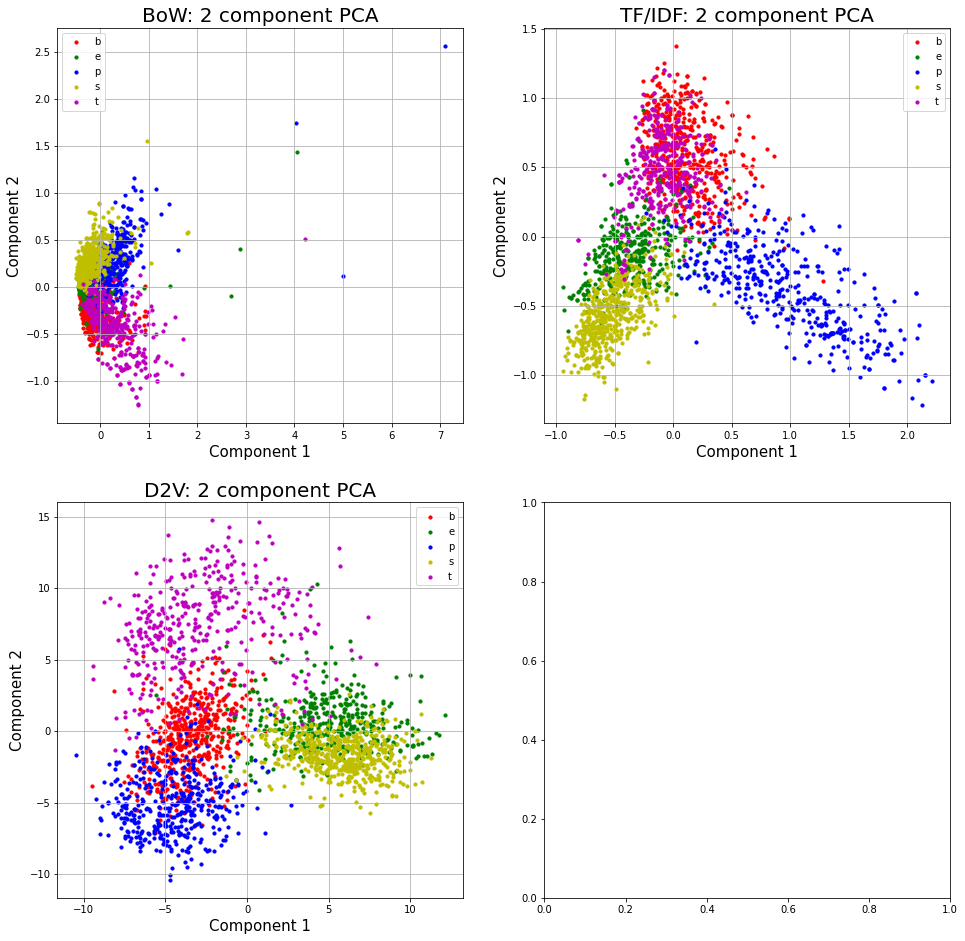

In [150]:
visualize_2d_projection(X_bow_pca, X_tfidf_pca, X_d2v_pca,
                        '2 component PCA', ['r', 'g', 'b', 'y', 'm'], 
                        ['b', 'e', 'p', 's', 't'])

#### SVD (Singular Value Decomposition)

From the documentation:<br>
*Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.*<br>
<br>

*In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).*

In [152]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)

X_bow_svd = svd.fit_transform(X_bow_scaled)
X_tfidf_svd = svd.fit_transform(X_tfidf)
X_d2v_svd = svd.fit_transform(X_d2v_scaled)

*(For the BoW and D2V we use the scaled values, as they produce better results)*

Visualize 2-D projection

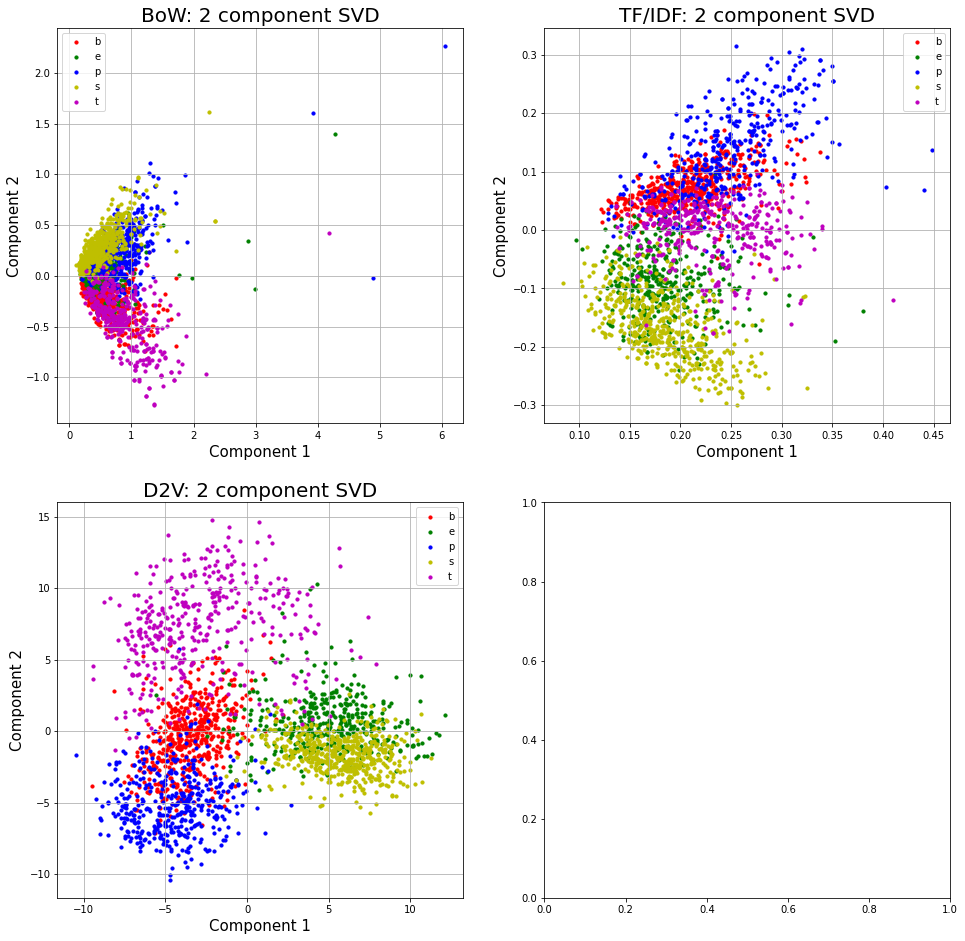

In [153]:
visualize_2d_projection(X_bow_svd, X_tfidf_svd, X_d2v_svd,
                        '2 component SVD', ['r', 'g', 'b', 'y', 'm'], 
                        ['b', 'e', 'p', 's', 't'])

#### ICA (Independent Component Analysis)

Since the ICA model does not include a noise term, for the model to be correct, whitening must be applied.<br>
We do this internally using the whiten argument

In [154]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2, whiten=True)

X_bow_ica = ica.fit_transform(X_bow.todense())
X_tfidf_ica = ica.fit_transform(X_tfidf.todense())
X_d2v_ica = ica.fit_transform(X_d2v)

Visualize 2-D projection

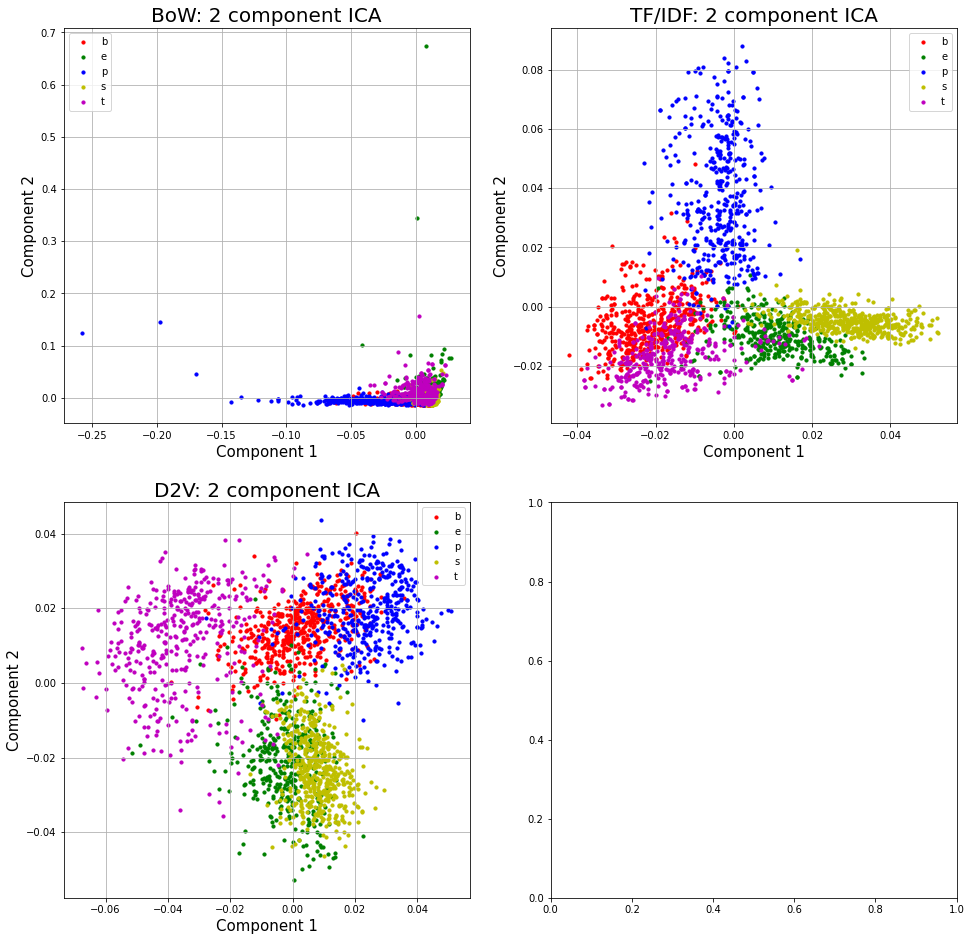

In [155]:
visualize_2d_projection(X_bow_ica, X_tfidf_ica, X_d2v_ica,
                        '2 component ICA', ['r', 'g', 'b', 'y', 'm'], 
                        ['b', 'e', 'p', 's', 't'])

#### NOTE:
The BoW projections look very bad, this is because they are not normalized. This is done purposely.

### c) Clustering and Plotting the data

The `sklearn.cluster.KMeans` clusterer uses Euclidian distance.<br>
We will be **normalizing the dataset** using `sklearn.preprocessing.normalize`.<br>
Then we can run KMeans (using Euclidean distance), and **it will be the same as if we had changed the distance metric to Cosine distance.**<br>
<br>
*(Source: https://stats.stackexchange.com/questions/299013/cosine-distance-as-similarity-measure-in-kmeans)*

In [96]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, init ='k-means++')

The following function will be used to compare the actual categories of the 2-D projections of documents to the KMeans++ clusters.<br>
<br>
It creates three graphs:<br>
   - One showing the clusters created by Kmeans
   - One showing the projections of the documents and their actual categories
   - One highlighting the documents incorrectly classified by kmeans<br>
<br>
<b>Returns:</b> dataframe showing the distribution of each document type in each named cluster.<br>
It names each cluster using the majority label of the documents in that cluster.

In [104]:
def kmeans_clustering_analysis(X_data, y_kmeans, title, colors, errorcolor='cyan'):
    # Create figure and axes
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
    # create a dictionary for the category names and their colors
    categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
    category_colors = dict(zip(categories, colors))
    # k means has created clusters with names from 0-4
    cluster_ids = [0, 1, 2, 3, 4]
    # name each cluster using the majority label of the documents in that cluster
    cluster_names = [datadf.loc[y_kmeans ==i, 'category'].mode().iloc[0] for i in cluster_ids]
    
    # ax1 clustering
    for target, cluster in zip(cluster_ids, cluster_names):
        # all indices of points in cluster
        indicesToKeep = y_kmeans ==target
        # points of cluster painted the color of cluster
        ax1.scatter(X_data[indicesToKeep, 0],
                    X_data[indicesToKeep, 1],
                    c = category_colors[cluster],
                    s = 10)
        
        ax1.legend(cluster_names)
        ax1.set_xlabel('Component 1', fontsize = 10)
        ax1.set_ylabel('Component 2', fontsize = 10)
        ax1.set_title('KMeans++ with '+title, fontsize = 15)
        ax1.grid()
    
    # ax2 projection of actual categories
    targets = ['b', 'e', 'p', 's', 't']
    for category in categories:
        indicesToKeep = datadf['category'] == category
        ax2.scatter(X_data[indicesToKeep, 0],
                    X_data[indicesToKeep, 1],
                    c = category_colors[category],
                    s = 10)
    
    ax2.legend(targets)
    ax2.set_xlabel('Component 1', fontsize = 10)
    ax2.set_ylabel('Component 2', fontsize = 10)
    ax2.set_title(title, fontsize = 15)
    ax2.grid()
    
    # ax3 clustering errors
    for target, cluster in zip(cluster_ids, cluster_names):
        # all indices of points in cluster
        indicesToKeep = y_kmeans ==target
        # indices whose category is the same as the cluster name
        correctCluster = datadf['category'] == cluster
        # points clustered correctly painted the color of cluster
        ax3.scatter(X_data[indicesToKeep&correctCluster, 0],
                   X_data[indicesToKeep&correctCluster, 1],
                   c = category_colors[cluster],
                   s = 10)
        # points clustered incorrectly painted cyan
        ax3.scatter(X_data[indicesToKeep&~correctCluster, 0],
                   X_data[indicesToKeep&~correctCluster, 1],
                   c = errorcolor,
                   s = 10)
        
    ax3.legend(cluster_names)
    # set legend colors
    for target, cluster in zip(cluster_ids, cluster_names):
        ax3.get_legend().legendHandles[target].set_color(category_colors[cluster])
    ax3.set_xlabel('Component 1', fontsize = 10)
    ax3.set_ylabel('Component 2', fontsize = 10)
    ax3.set_title('KMeans++ errors with '+title, fontsize = 15)
    ax3.grid()

    plt.show()
    
    
    # Distribution of document's actual categories in each cluster
    analytics = pd.concat([datadf.loc[y_kmeans==t]\
                           .groupby('category')['title'].count().rename("Cluster "+name)\
                           for t, name in zip(cluster_ids, cluster_names)], 
                          axis=1)
    
    # before returning the dataframe, fill nan with zeros, change type to int32
    # and sort on both axes
    return analytics.fillna(0).astype('int32').sort_index().sort_index(axis=1)

#### PCA (Principal Component Analysis)

In [98]:
y_kmeans_bow_pca = kmeans.fit_predict(normalize(X_bow_pca))
y_kmeans_tfidf_pca = kmeans.fit_predict(normalize(X_tfidf_pca))
y_kmeans_d2v_pca = kmeans.fit_predict(normalize(X_d2v_pca))

*Multiple fit_predict calls are do not influence each other. Every time we execute `model.fit(X_train, y_train)`, it overwrites all previously fitted coefficients, weights, intercept (bias), etc.*

Compare PCA 2-D projections of documents to the KMeans++ clusters

In [ ]:
kmeans_clustering_analysis(X_bow_pca, y_kmeans_bow_pca, 
                           "BoW:PCA", ['r', 'g', 'b', 'y', 'm'], 'cyan')

In [ ]:
kmeans_clustering_analysis(X_tfidf_pca, y_kmeans_tfidf_pca,
                           "TFIDF:PCA", ['r', 'g', 'b', 'y', 'm'], 'cyan')

In [ ]:
kmeans_clustering_analysis(X_d2v_pca, y_kmeans_d2v_pca,
                           "D2V:PCA", ['r', 'g', 'b', 'y', 'm'], 'cyan')

#### SVD (Singular Value Decomposition)

In [107]:
y_kmeans_bow_svd = kmeans.fit_predict(normalize(X_bow_svd))
y_kmeans_tfidf_svd = kmeans.fit_predict(normalize(X_tfidf_svd))
y_kmeans_d2v_svd = kmeans.fit_predict(normalize(X_d2v_svd))

Compare SVD 2-D projections of documents to the KMeans++ clusters

In [ ]:
kmeans_clustering_analysis(X_bow_svd, y_kmeans_bow_svd,
                           "BoW:SVD", ['r', 'g', 'b', 'y', 'm'], 'cyan')

In [ ]:
kmeans_clustering_analysis(X_tfidf_svd, y_kmeans_tfidf_svd,
                           "TFIDF:SVD", ['r', 'g', 'b', 'y', 'm'], 'cyan')

In [ ]:
kmeans_clustering_analysis(X_d2v_svd, y_kmeans_d2v_svd,
                           "D2V:SVD", ['r', 'g', 'b', 'y', 'm'], 'cyan')

#### ICA (Independent Component Analysis)

In [110]:
from sklearn.preprocessing import normalize

y_kmeans_bow_ica = kmeans.fit_predict(normalize(X_bow_ica))
y_kmeans_tfidf_ica = kmeans.fit_predict(normalize(X_tfidf_ica))
y_kmeans_d2v_ica = kmeans.fit_predict(normalize(X_d2v_ica))

Compare ICA 2-D projections of documents to the KMeans++ clusters

In [ ]:
kmeans_clustering_analysis(X_bow_ica, y_kmeans_bow_ica, 
                           "BOW:ICA", ['r', 'g', 'b', 'y', 'm'])

In [ ]:
kmeans_clustering_analysis(X_tfidf_ica, y_kmeans_tfidf_ica, 
                           "TFIDF:ICA", ['r', 'g', 'b', 'y', 'm'])

In [ ]:
kmeans_clustering_analysis(X_d2v_ica, y_kmeans_d2v_ica, 
                           "D2V:ICA", ['r', 'g', 'b', 'y', 'm'])

### Comments:

 The best clustering (least number of errors) was found in the TF/IDF representation using the ICA compression method.<br>
 <br>
 In general the business, politics and tech documents were represented closer to each other.<br>
 Also the sports and entertainment documents were also usually close to each other.<br>
 <br>

#### Bag of Words
Bag of Words was in general the least successful of the document representations arrays.

- **ICA was the least effective of the compression methods with a total of 1155 errors.**<br>
There was no cluster with the majority of its documents being from the entertainment category.<br>
The tech and entertainment documents were almost evenly distributed in the clusters.<br>
- **PCA was the most effective with a total of 865 errors.**<br>
Errors were mostly caused by sport documents in the entertainment cluster
- **SVD was somewhere in the middle of the two others with 1076 errors.** <br>
Here the document representations of tech and business categories were close together. <br>
The politics and entertainment documents were quite evenly distributed in the clusters.<br>

#### TFIDF
TFIDF was very successful in the document representations arrays.
Some entertainment respresentations were very similar to the tech represenations, and this was evident in all compression methods.

- **ICA was the most effective of the compression methods with a total of 508 errors.**<br>
Many of the <u>business</u> documents were found in the <u>tech</u> cluster (causing the greatest amount of errors)<br>
Also, an interesting amount entertainment documents were found in the sports cluster
- **PCA was the least effective with a total of 827 errors.**<br>
There was no cluster with the majority of its documents being from the tech category.<br>
This was caused by the <u>business</u> and <u>tech</u> documents representations being too close.
- **SVD was somewhere in the middle of the two others with 752 errors.** <br>
The <u>business</u> and <u>politics</u> representations were found very close. Many business documents were found in the politics cluster and vise versa.<br>
Similar phenomenon (but less strong) was noticed in the entertainment and sports clusters.

#### D2V
D2V was the most successful of the document representations arrays.
In all the compression methods the location of the documents was very similar, causing similar results in the clustering.<br>
1) many <u>business</u> documents were found in the <u>politics</u> and <u>tech</u> clusters<br>
2) many entertainment documents ended up in the sports cluster

- **ICA was the least effective of the compression methods with a total of 613 errors.**<br>

- **PCA was the most effective with a total of 588 errors.**<br>

- **SVD was somewhere in the middle of the two others with 592 errors.** <br>
